# Import Data from Kaggle

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Upload kaggle.json to the folder directory

and run the below cells to import the required data.

In [1]:
# Make a directory named '.kaggle'
!mkdir -p ~/.kaggle

# Move kaggle.json into this directory
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# download requiree dataset based on username and dataset name
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 54.9MB/s]


In [3]:
# Unzip the dataset
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


# Import Necessary Libraries

In [4]:
! pip install pygam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 850.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 873.6 kB/s eta 0:00:00


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score, f1_score

from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log
from statsmodels.genmod import families
import statsmodels.api as sm
from statsmodels.tools import add_constant
from pygam import LogisticGAM, GammaGAM, s

# Exploratory Data Analysis

In [25]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [27]:
df.info()  # No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [28]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [29]:
# TotalCharges column is not being described above meaning it has some non-numerical values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [30]:
print("Before: ", df.shape)
df.drop_duplicates(inplace=True)
print("After: ", df.shape)

Before:  (7043, 21)
After:  (7043, 21)


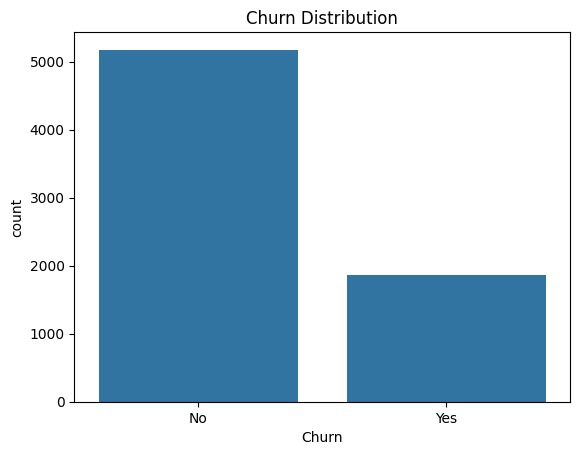

In [31]:
# Plotting churn distribution
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

Plot shows significant class imbalance. There is ~3x more data for customers retained as compared to customers who left.

In [32]:
# basic cleaning
df = df.drop(['customerID'], axis=1)

In [33]:
# Convert binary categorical features
df['gender'] = [1 if x == 'Male' else 0 for x in df['gender']]
df['Partner'] = [1 if x == 'Yes' else 0 for x in df['Partner']]
df['Dependents'] = [1 if x == 'Yes' else 0 for x in df['Dependents']]
df['PhoneService'] = [1 if x == 'Yes' else 0 for x in df['PhoneService']]
df['OnlineSecurity'] = [1 if x == 'Yes' else 0 for x in df['OnlineSecurity']]
df['OnlineBackup'] = [1 if x == 'Yes' else 0 for x in df['OnlineBackup']]
df['DeviceProtection'] = [1 if x == 'Yes' else 0 for x in df['DeviceProtection']]
df['TechSupport'] = [1 if x == 'Yes' else 0 for x in df['TechSupport']]
df['StreamingTV'] = [1 if x == 'Yes' else 0 for x in df['StreamingTV']]
df['StreamingMovies'] = [1 if x == 'Yes' else 0 for x in df['StreamingMovies']]
df['PaperlessBilling'] = [1 if x == 'Yes' else 0 for x in df['PaperlessBilling']]
df['Churn'] = [1 if x == 'Yes' else 0 for x in df['Churn']]

# One-hot encode remaining categorical features
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod', 'MultipleLines'], drop_first=True)
# Turn False and True to 0s and 1s
df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))


df.head()

<ipython-input-33-bfccb5d1f326>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No phone service,MultipleLines_Yes
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,34,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,2,1,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,45,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,2,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


# Linear Regression Model Assumptions

- Linearity: underlying relationship between X and y is linear
- Independence: residuals are independent
- Homoscedasticity: Residuals have constant variance
- Normality: Residuals are normally distributed
- No multicollinearity

# Checking Assumption: Linearity
Since the target variable under consideration i.e., Churn is categorical, the assumption of linearity between the features and the dependent variable (churn) won't hold well. This is evident from plots below.

We can assume that this assumption is not met and the linear regression model will perform subpar, if used.

### Examining Relationships between various features and target variable churn

<Axes: xlabel='tenure', ylabel='Churn'>

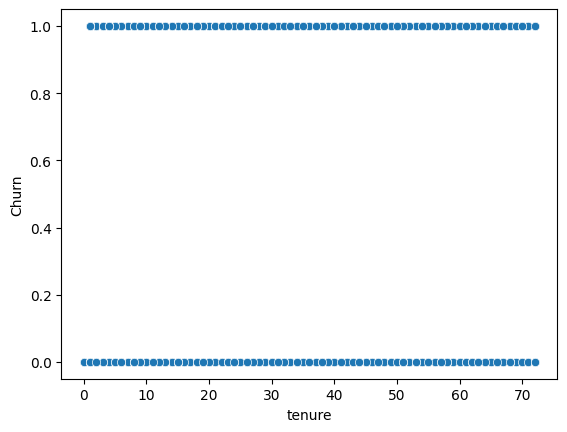

In [34]:
sns.scatterplot(x='tenure', y='Churn', data=df)

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

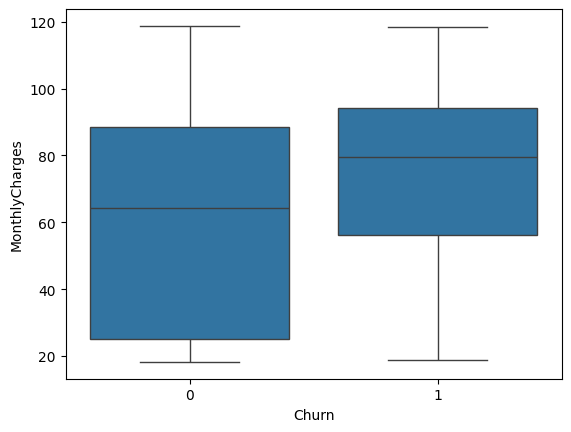

In [35]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)

## Checking Assumption: Colinearity


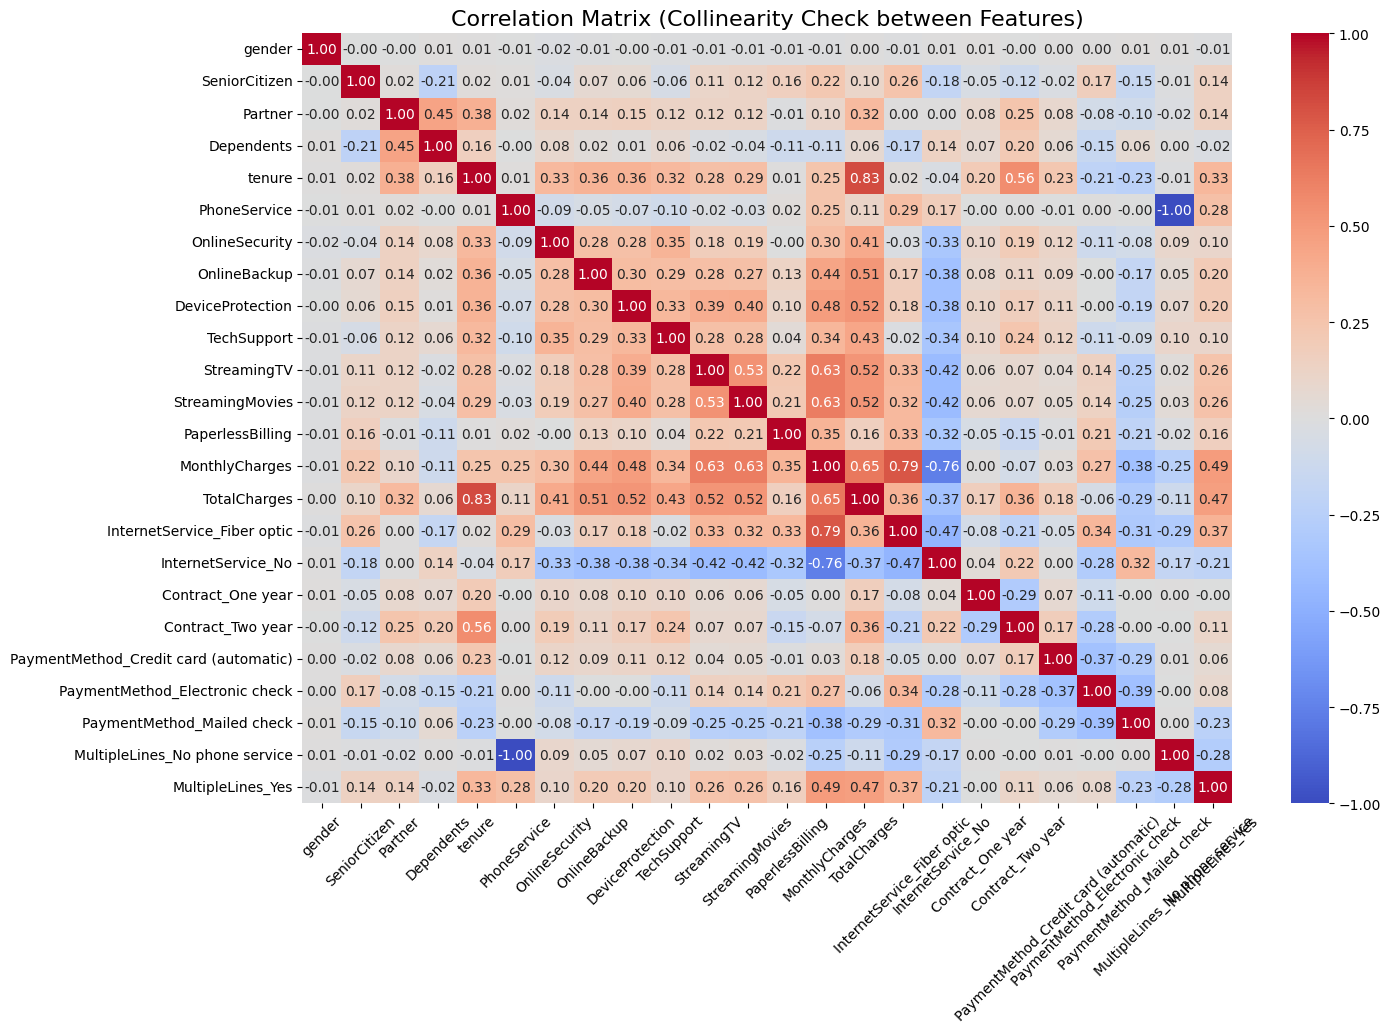

In [36]:
# Plotting the correlation matrix to check feature colinearity
features = df.drop(columns=['Churn'])
corr_matrix = features.corr()
plt.figure(figsize=(15, 10))


sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 10}, fmt=".2f")

plt.title('Correlation Matrix (Collinearity Check between Features)', fontsize=16)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.show()

Upon analyzing the correlation matrix below, we can see relatively high collinearity between
1. MonthlyCharges and TotalCharges (correlation = 0.82).
2. PhoneService and MultipleLine_No Phone Service (corelation = -1)
3. InternetService Fiber Optic and PaperlessBilling (0.76)
4. InternetService Fiber Optic and InternetService No (-0.79)

Since co-linearity is not a "deal breaker" assumption, we can try 3 options

1. Dropping one of the co-related features like dropping `TotalCharges`, `MultipleLine_No Phone Service` and `InternetService Fiber Optic`  from the model to reduce redundancy and multicollinearity. Removing highly correlated features helps to ensure that our model coefficients remain stable and interpretable. Ideally this would

2. Keep all features and test the model. Attempting to check whether we can increase accuracy with a less interpretable model.

# Split data into Training and Testing + Data Standardization

In [37]:
# SOLUTION 1
df_lir = df.drop(columns=['TotalCharges', 'MultipleLines_No phone service', 'InternetService_Fiber optic'], axis=1)

In [38]:
y = df_lir['Churn']
X = df_lir.drop('Churn', axis=1)
cols = X.columns

X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Using the Ordinary Least Squares Regression or Linear Regression from StatModel
X = sm.add_constant(X_train, prepend=False)
model = sm.OLS(y_train, X)
result = model.fit()
coefs = result.params
error = result.bse
names = list(cols) + ['intercept']

In [40]:
print(result.summary(xname=names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     99.91
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:12:44   Log-Likelihood:                -2494.8
No. Observations:                5634   AIC:                             5034.
Df Residuals:                    5612   BIC:                             5180.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Above is the statsmodel summary of the linear regression model for churn based on a variety of independent variables.

### Interpreting Coefficients
Each coefficient represents the change in Churn for a one-unit change in the corresponding feature. Positive Coefficients indicate that as the feature value increases, the likelihood of Churn also increases and vice-versa.
Intercept value of 0.3183 indicates the baseline probability of churn when all predictors are zero.

### R-squared = 0.272

Thhe model explains only 27.2% of the variance in the target variable (Churn). This is relatively low, so we are not capturing a a significant amount of variability by using Linear Regression.
The adjusted R-squared is slightly lower, indicating that some of the variability might be due to the inclusion of additional predictors that do not improve the model significantly.

### Reason
Linear regression assumes that the relationship between predictors and the target variable is linear. However, with a binary outcome, the probability of Churn is not necessarily linearly related to the predictors which we had also established above.

Now we will check if any other Linear Regression assumptions are being violated

In [47]:
sum(result.params)

-0.23359088655199522

In [41]:
# Fit regression model
lr = LinearRegression()
model_lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Root mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

Root mean squared error: 0.37


RMSE of 0.37 here indicates that the predictions here are off by a value of 0.37 which is not good when prediction 0s and 1s ofcourse.

In [42]:
# ValueError: Input X contains NaN.
df.isna().any()

,0
gender,False
SeniorCitizen,False
Partner,False
Dependents,False
tenure,False
PhoneService,False
OnlineSecurity,False
OnlineBackup,False
DeviceProtection,False
TechSupport,False


In [43]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [44]:
# Checking whether the accuracy of the model increases if No features are dropped i.e. even features with high multi-collinearity are reatined
y = df['Churn']
X = df.drop('Churn', axis=1)
cols = X.columns

X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Fit regression model
lr = LinearRegression()
model_lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Root mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

# The added features donot seem to making any improvement to the linear regression model

Root mean squared error: 0.37


## Checking Assumption:
- Homoscedasticity: Residuals have constant variance

From the plot we can see that the variance of the residuals is changing systematically with the fitted values. So it violates one of the key assumptions of linear regression.

- Independence:

From the below plot, systematic line patterns indicate that Independence of variables is being violated

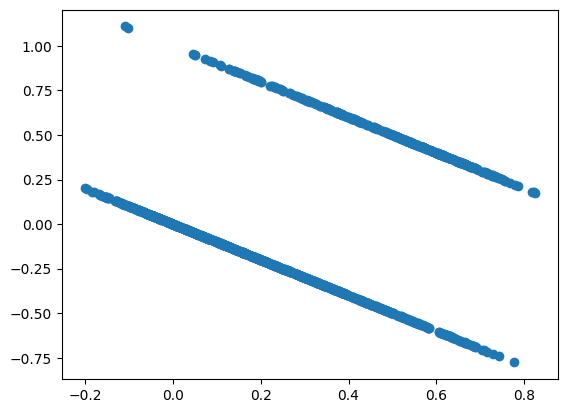

In [48]:
plt.scatter(y_pred, y_test-y_pred)

## Checking Assumption:
- Normality: Residuals are normally distributed

Based on the below graph, the residuals deviate from the line quite a bit at times, indicating that they may violate the assumption of normality.

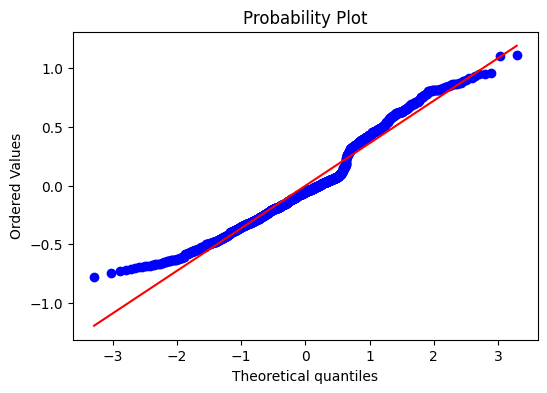

In [49]:
import scipy as sp

fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(y_test-y_pred, plot=ax, fit=True)
plt.show()

# Logistic Regression Model Assumptions

- Output variable should be categorical: Churn is a categorical variable so satisfied
- Linearity: linear relationship between the continuous predictors and the log-odds of the outcome
- No multicollinearity: Checked using the corelation matric before
- Independence of observations: Since each row of the dataframe is an independent record or a new customer, we can assume this condition is met
- No influential outliers
- Absence of perfect separation
- Large sample size: With 5000 and 2000 data points for each class churner and non churners respectively, we can conclude that the data size is sufficiently large.


## Check Assumption: Output variable should be categorical: Churn is a categorical variable so satisfied

In [52]:
df['Churn'].nunique()

2

## Checking Assumption: Absense of perfect seperation

<Axes: xlabel='tenure', ylabel='Churn'>

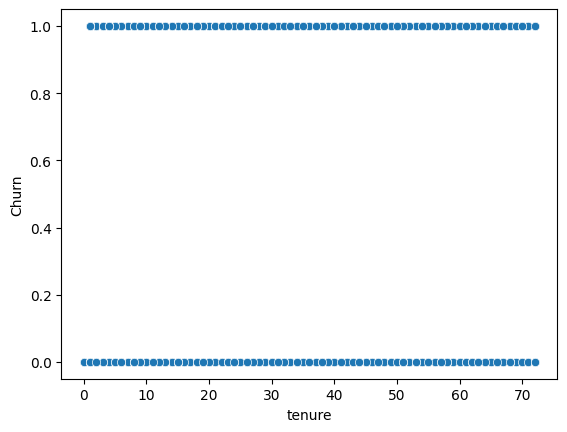

In [53]:
sns.scatterplot(x='tenure', y='Churn', data=df)

<Axes: xlabel='MonthlyCharges', ylabel='Churn'>

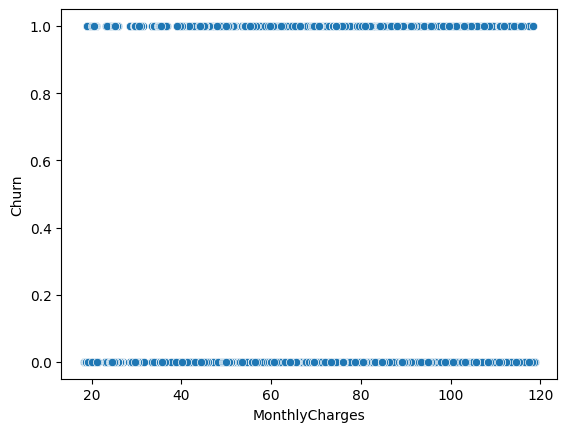

In [54]:
sns.scatterplot(x='MonthlyCharges', y='Churn', data=df)

<Axes: xlabel='TotalCharges', ylabel='Churn'>

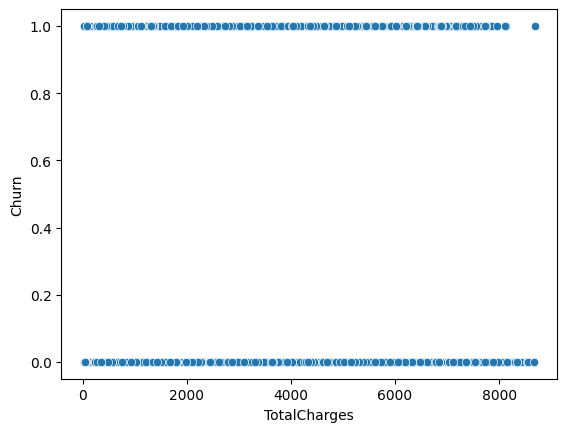

In [55]:
sns.scatterplot(x='TotalCharges', y='Churn', data=df)

All three plots (corresponding to the continuous variables in the dataframe) clearly show that there is NO clear seperation for the target variable thus fulfilling the assumption.

## Checking Assumption: No Influential Outliers
1. Some outliers have the potential to be influetial.
2. Using Cooks distance to meansure the influence of a data point.

Reference: https://github.com/sandipanpaul21/Logistic-regression-in-python/blob/main/07_LR_Assumptions.ipynb

In [59]:
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                            GLM   Df Residuals:                     7019
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2915.1
Date:                Wed, 18 Sep 2024   Deviance:                       5830.2
Time:                        14:37:22   Pearson chi2:                 8.01e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2806
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [60]:
from scipy import stats

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()

,cooks_d,std_resid
0,0.000485,1.250531
1,0.000002,0.202346
2,0.000452,1.420977
3,0.000002,0.169752
4,0.000038,0.615732


Threshold for Cook Distance = 0.0005679397983813716
Proportion of data points that are highly influential = 5.2%


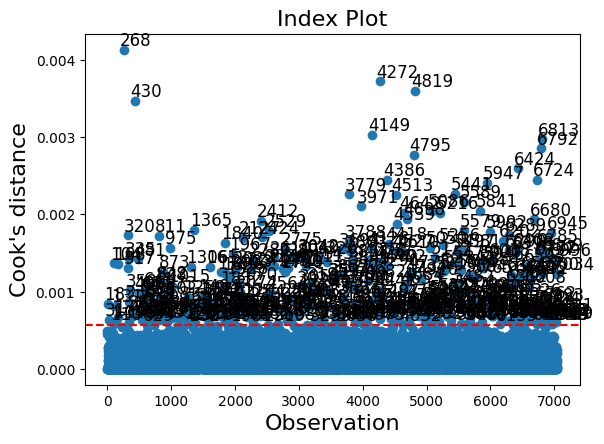

In [62]:
# Set Cook's distance threshold
cook_threshold = 4 / len(df)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(df)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

In [64]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(df)),1)


# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
268,0.004132,17.347581
4272,0.003723,11.818480
4819,0.003602,15.535419
430,0.003469,8.157388
4149,0.003032,6.298047


In [65]:
df.iloc[268]

,268
gender,1.00
SeniorCitizen,0.00
Partner,0.00
Dependents,0.00
tenure,59.00
PhoneService,1.00
OnlineSecurity,0.00
OnlineBackup,0.00
DeviceProtection,0.00
TechSupport,0.00


In [ ]:
from scipy import stats

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()

Since,

Proportion of data points that are highly influential = 5.2%

which is relatively a small number of points in the influential outlier zone, we will retain all values for the logistic regression since taking the call on whether to drop or retain requires a subject-matter i.e., dataset expert opinion.


## Modeling Logistic Regression

In [50]:
y = df['Churn']
X = df.drop('Churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.82
ROC-AUC: 0.86
Confusion Matrix:
[[933 103]
 [148 225]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



In [51]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0],
    'Odds Ratio': np.exp(log_reg.coef_[0])
})
print(coefficients)

                                  Feature  Coefficient  Odds Ratio
0                                  gender    -0.048257    0.952889
1                           SeniorCitizen     0.164485    1.178785
2                                 Partner     0.059283    1.061076
3                              Dependents    -0.164374    0.848424
4                                  tenure    -0.056139    0.945407
5                            PhoneService    -0.576139    0.562064
6                          OnlineSecurity    -0.511588    0.599543
7                            OnlineBackup    -0.250945    0.778065
8                        DeviceProtection    -0.093335    0.910888
9                             TechSupport    -0.427981    0.651824
10                            StreamingTV     0.063909    1.065995
11                        StreamingMovies     0.165798    1.180334
12                       PaperlessBilling     0.340165    1.405180
13                         MonthlyCharges     0.008913    1.00

## Interpreting the Coefficients
Each coefficient in a logistic regression model represents the change in the log-odds of the target variable for a one-unit change in that predictor, holding all other predictors constant.

For example, if we look at the gender coefficient value, being male is associated with a slight decrease in the odds of churn (since I had assigned male=1). An odds ratio of 0.95 means that males are 5% less likely to churn compared to females.

Similarly, senior citizens have about 18% higher odds of churning compared to non-senior citizens.

## Interpreting the Metrics
The classification metrics indicates that the model performs well for non-churners but less effectively for churners since the recall for churners is relatively low, which suggests the model misses many of the actual churn cases. This may be reflective of the fact the the data is imbalanced with a lot more observations for non-churners, making the model overfit to the majority class.

Recall of the model may be improved by using over sampling techniques for the minority class.


## Checking Assumptions

1. Linearity: linear relationship between the continuous predictors and the log-odds of the outcome

Since there is a clear trend for both the features, we can conclude that a simple linear term may not be enough to capture the relation between the target variable and the feature in question. More accuarte results will most likely need non-linearity in the model.

In [159]:
# Predicting probabilities and computing log odds
probs = log_reg.predict_proba(X)[:, 1]
log_odds = np.log(probs / (1 - probs))

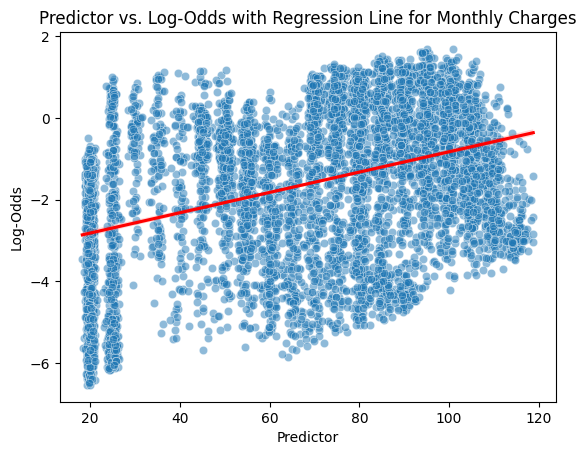

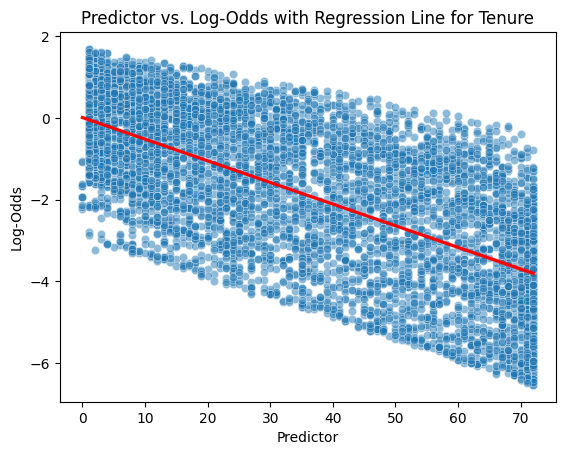

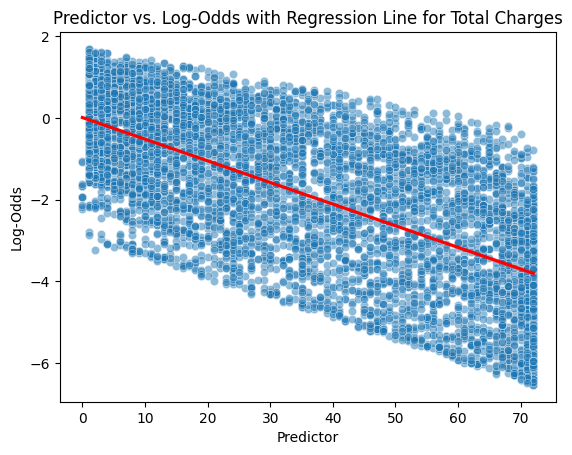

In [160]:
import seaborn as sns

predictor1 = X['MonthlyCharges']
predictor2 = X['tenure']
predictor3 = X['TotalCharges']

# Plot with a regression line
sns.scatterplot(x=predictor1, y=log_odds, alpha=0.5)
sns.regplot(x=predictor1, y=log_odds, scatter=False, color='red')
plt.xlabel('Predictor')
plt.ylabel('Log-Odds')
plt.title('Predictor vs. Log-Odds with Regression Line for Monthly Charges')
plt.show()

sns.scatterplot(x=predictor2, y=log_odds, alpha=0.5)
sns.regplot(x=predictor2, y=log_odds, scatter=False, color='red')
plt.xlabel('Predictor')
plt.ylabel('Log-Odds')
plt.title('Predictor vs. Log-Odds with Regression Line for Tenure')
plt.show()

sns.scatterplot(x=predictor2, y=log_odds, alpha=0.5)
sns.regplot(x=predictor2, y=log_odds, scatter=False, color='red')
plt.xlabel('Predictor')
plt.ylabel('Log-Odds')
plt.title('Predictor vs. Log-Odds with Regression Line for Total Charges')
plt.show()

1. The first scatterplot shows a roughly linear increasing trend. There is some scatter, but overall it seems to follow a linear pattern.

2. Shows a clear neagtive relationship

3. Shows a clear negative relationship

Thus we can conclude that all plots show linear relationships thus fulfilling the linearity assumption for logistic regression.


# Generalized Additive Model (GAM)

## Assumptions
1. Independence of observations - Checked before
2. No multicollinearity among predictors
3. Homoscedasticity (constant variance)
4. Large enough sample size - With 5000 and 2000 data points for each class churner and non churners respectively, we can conclude that the data size is sufficiently large.

In [67]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# represents a spline function for each feature in the dataset
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23),
                   n_splines=20, lam=0.6)

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:01:08 Time:  0:01:08


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + intercept,
   tol=0.0001, verbose=False)

In [83]:
# Make predictions
y_pred_prob_gam = gam.predict_proba(X_test_scaled)

# to get a balanace of recall and presicion we will set the threshold to 0.4
threshold = 0.4
y_pred_gam = (y_pred_prob_gam > threshold).astype(int)

# Calculate various metrics
accuracy = accuracy_score(y_test, y_pred_gam)
precision = precision_score(y_test, y_pred_gam)
recall = recall_score(y_test, y_pred_gam)
f1 = f1_score(y_test, y_pred_gam)
auc = roc_auc_score(y_test, y_pred_prob_gam)  # Use probabilities for AUC-ROC

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Classification report (provides precision, recall, F1-score, and support)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gam))

Accuracy: 0.8077
Precision: 0.6250
Recall: 0.6836
F1 Score: 0.6530
AUC-ROC: 0.8618

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1036
           1       0.62      0.68      0.65       373

    accuracy                           0.81      1409
   macro avg       0.75      0.77      0.76      1409
weighted avg       0.81      0.81      0.81      1409



Accuracy indicates that the model correctly predicted the outcome for 81% of the instances.

Precision tells us that out of all instances that were predicted positive, only 62% were actually positive.

Recall (0.68): Out of all churn instances, the model correctly identified 68%.

F1 Score (0.65): mean of precision and recall. 65% is not a great model.

In [84]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     34.3604
Link Function:                        LogitLink Log Likelihood:                                 -2304.2162
Number of Samples:                         5634 AIC:                                             4677.1533
                                                AICc:                                            4677.6127
                                                UBRE:                                                2.835
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2933
Feature Function                  Lam

<ipython-input-84-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


## Interpretation
1. 29% of the variability in the target (churn) is explained by the model based on the psuedo R2 value.

2. P-values give us an idea about how significant the features are. From the above model summary we can conclude
Highly significant features include s(4), s(16), s(17), s(18), and others, which likely play a strong role in predicting churn.
Less significant or irrelevant features include s(0), s(1), s(2), etc.

Although, The p-values may be artificially lower than they should be due to the way the smoothing parameters as suggested by the warning so not sure how trustworthy these interpretationa are.

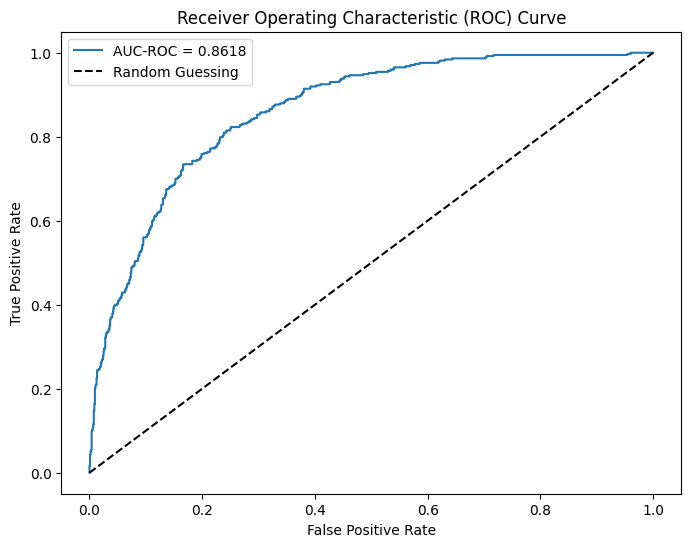

In [82]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gam)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Model Comparison
## 1. Linear Regression:

1. Simple, interpretable and provides direct coefficients for feature impact.
2. But assumes linear relationships between features and target, which is not the case with the data we are modeling.

## 2. Logistic Regression:

1. Logistic regression provides odds ratios that are interpretable and offer clear insights into how each feature impacts the likelihood of an outcome, making it well-suited for binary classification tasks.
2. Results are decent (bias towards the majority class) and interpretable.

## 3.Generalized Additive Model (GAM):
. GAMs are well-suited for capturing non-linear relationships through the use of splines, allowing each feature to contribute to the target variable in a flexible, non-linear fashion.
2. While GAM offers valuable insights into how individual features affect the target variable non-linearly, it introduces more complexity compared to linear or logistic regression models.
3. While the results of the model above are decent and comparable with logistic regression, we will prefer logistic regression here since its more interpretable and we dont have to worry about any potential "warnings".


# Recommendation
## Logistic Regression:
Given its good performance metrics (accuracy, ROC-AUC) and interpretability, given the options, logistic regression seems to be the best model for understanding customer churn. It provides clear insights into feature importance and how each feature influences the probability of churn.

If capturing non-linear relationships becomes critical, further tuning of the GAM or exploring other non-linear models might be worthwhile.